In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
os.chdir("/content/drive/App/EnhanceNet")

2688


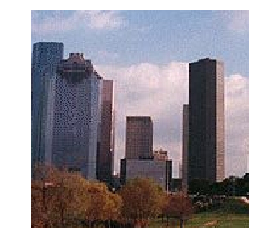

In [2]:
#import cv2
from PIL import Image
image_files = os.listdir("/content/drive/App/CVAE/natural_images")
#trainX = np.ndarray((len(image_files),256,256,3))
trainX = []
print(len(image_files))
for i, file in enumerate(image_files):
  if i%10 == 0 and file.endswith(".jpg"):
    img = Image.open("/content/drive/App/CVAE/natural_images/"+file).convert('RGB')
    w, h = img.size
#   ar = cv2.cvtColor(cv2.imread("/content/drive/App/CVAE/natural_images/"+file),cv2.COLOR_BGR2RGB)
    trainX.append(np.array(img)/255)
#trainX = trainX/255
trainX = np.asarray(trainX)
plt.axis("off")
plt.imshow(trainX[0])

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_test = train_test_split(trainX, test_size = 0.1, random_state=2)

In [0]:
import tensorflow.contrib.layers as lays
def autoencoder(inputs):
  with tf.variable_scope("CAE", reuse = tf.AUTO_REUSE) :
    net = lays.conv2d(inputs, 3, [3, 3], stride=2, padding='SAME')
    net = lays.conv2d(net, 3, [3, 3], stride=2, padding='SAME')
    net0 = lays.conv2d(net, 3, [3, 3], stride=2, padding='SAME')
    #net = lays.conv2d(net, 3, [3, 3], stride=2, padding='SAME')
    
    upsampled256 = tf.image.resize_bicubic(net, (256,256))
    upsampled128 = tf.image.resize_bicubic(net, (128,128))
    upsampled64 = tf.image.resize_bicubic(net, (64,64))

    net1 = lays.conv2d_transpose(net0, 3, [3, 3], stride=2, padding='SAME')
    net1 = tf.add(net1,upsampled64)
    net2 = lays.conv2d_transpose(net1, 3, [3, 3], stride=2, padding='SAME')
    net2 = tf.add(net2,upsampled128)
    net3 = lays.conv2d_transpose(net2, 3, [3, 3], stride=2, padding='SAME', activation_fn=tf.nn.sigmoid)
    net3 = tf.add(net3,upsampled256)
  return [net3,net1]

In [0]:
batch_size = 10
epoch_num = 1000
lr = 0.001
batch_per_ep = x_train.shape[0] // batch_size

In [0]:
ae_inputs = tf.placeholder(tf.float32, (None, 256, 256, 3))
ae_LR_inputs = tf.image.resize_bicubic(ae_inputs, (64,64))
ae_outputs,ae_LR_outputs = autoencoder(ae_inputs)           #tf.image.resize_bicubic(temp, (256,256))
loss = 0.9*tf.reduce_mean(tf.square(ae_LR_outputs - ae_LR_inputs)) + 0.1*tf.reduce_mean(tf.square(ae_outputs - ae_inputs))
train_op = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [7]:
all_vars = tf.global_variables()
model_one_vars = [k for k in all_vars if k.name.startswith("CAE")]
set_1 = set(model_one_vars)
print(len(all_vars))
print(len(model_one_vars))
model_two_vars = [o for o in all_vars if o not in set_1]
print(model_two_vars)
for i in tf.trainable_variables() :
  print(i)

38
36
[<tf.Variable 'beta1_power:0' shape=() dtype=float32_ref>, <tf.Variable 'beta2_power:0' shape=() dtype=float32_ref>]
<tf.Variable 'CAE/Conv/weights:0' shape=(3, 3, 3, 3) dtype=float32_ref>
<tf.Variable 'CAE/Conv/biases:0' shape=(3,) dtype=float32_ref>
<tf.Variable 'CAE/Conv_1/weights:0' shape=(3, 3, 3, 3) dtype=float32_ref>
<tf.Variable 'CAE/Conv_1/biases:0' shape=(3,) dtype=float32_ref>
<tf.Variable 'CAE/Conv_2/weights:0' shape=(3, 3, 3, 3) dtype=float32_ref>
<tf.Variable 'CAE/Conv_2/biases:0' shape=(3,) dtype=float32_ref>
<tf.Variable 'CAE/Conv2d_transpose/weights:0' shape=(3, 3, 3, 3) dtype=float32_ref>
<tf.Variable 'CAE/Conv2d_transpose/biases:0' shape=(3,) dtype=float32_ref>
<tf.Variable 'CAE/Conv2d_transpose_1/weights:0' shape=(3, 3, 3, 3) dtype=float32_ref>
<tf.Variable 'CAE/Conv2d_transpose_1/biases:0' shape=(3,) dtype=float32_ref>
<tf.Variable 'CAE/Conv2d_transpose_2/weights:0' shape=(3, 3, 3, 3) dtype=float32_ref>
<tf.Variable 'CAE/Conv2d_transpose_2/biases:0' shape=(3,

In [0]:
with tf.Session() as sess:
    sess.run(init)
    for ep in range(epoch_num): 
        for batch_n in range(batch_per_ep): 
            batch_img = x_train[batch_n*batch_size:batch_n*batch_size+batch_size]            
            _, c = sess.run([train_op, loss], feed_dict={ae_inputs: batch_img})
        print('Epoch: {} - cost= {:.5f}'.format((ep + 1), c))
    # test the trained network
    save_path = saver.save(sess, "/content/drive/App/EnhanceNet/models/model.ckpt")
    batch_img = x_test
    recon_LR_img, recon_HR_img = sess.run([ae_LR_outputs, ae_outputs], feed_dict={ae_inputs: batch_img})

Epoch: 1 - cost= 0.07198
Epoch: 2 - cost= 0.05347
Epoch: 3 - cost= 0.04851
Epoch: 4 - cost= 0.04211
Epoch: 5 - cost= 0.03678
Epoch: 6 - cost= 0.03255
Epoch: 7 - cost= 0.02944
Epoch: 8 - cost= 0.02699
Epoch: 9 - cost= 0.02489
Epoch: 10 - cost= 0.02287
Epoch: 11 - cost= 0.02092
Epoch: 12 - cost= 0.01920
Epoch: 13 - cost= 0.01769
Epoch: 14 - cost= 0.01643
Epoch: 15 - cost= 0.01540
Epoch: 16 - cost= 0.01453
Epoch: 17 - cost= 0.01378
Epoch: 18 - cost= 0.01311
Epoch: 19 - cost= 0.01251
Epoch: 20 - cost= 0.01196
Epoch: 21 - cost= 0.01146
Epoch: 22 - cost= 0.01099
Epoch: 23 - cost= 0.01055
Epoch: 24 - cost= 0.01014
Epoch: 25 - cost= 0.00975
Epoch: 26 - cost= 0.00939
Epoch: 27 - cost= 0.00904
Epoch: 28 - cost= 0.00870
Epoch: 29 - cost= 0.00838
Epoch: 30 - cost= 0.00808
Epoch: 31 - cost= 0.00779
Epoch: 32 - cost= 0.00751
Epoch: 33 - cost= 0.00725
Epoch: 34 - cost= 0.00700
Epoch: 35 - cost= 0.00676
Epoch: 36 - cost= 0.00653
Epoch: 37 - cost= 0.00632
Epoch: 38 - cost= 0.00611
Epoch: 39 - cost= 0.0

Epoch: 88 - cost= 0.00279
Epoch: 89 - cost= 0.00278
Epoch: 90 - cost= 0.00276
Epoch: 91 - cost= 0.00275
Epoch: 92 - cost= 0.00273
Epoch: 93 - cost= 0.00272
Epoch: 94 - cost= 0.00271
Epoch: 95 - cost= 0.00270
Epoch: 96 - cost= 0.00269
Epoch: 97 - cost= 0.00268
Epoch: 98 - cost= 0.00267
Epoch: 99 - cost= 0.00266
Epoch: 100 - cost= 0.00265
Epoch: 101 - cost= 0.00264
Epoch: 102 - cost= 0.00263
Epoch: 103 - cost= 0.00262
Epoch: 104 - cost= 0.00261
Epoch: 105 - cost= 0.00260
Epoch: 106 - cost= 0.00259
Epoch: 107 - cost= 0.00258
Epoch: 108 - cost= 0.00257
Epoch: 109 - cost= 0.00257
Epoch: 110 - cost= 0.00256
Epoch: 111 - cost= 0.00255
Epoch: 112 - cost= 0.00254
Epoch: 113 - cost= 0.00254
Epoch: 114 - cost= 0.00253
Epoch: 115 - cost= 0.00252
Epoch: 116 - cost= 0.00252
Epoch: 117 - cost= 0.00251
Epoch: 118 - cost= 0.00251
Epoch: 119 - cost= 0.00250
Epoch: 120 - cost= 0.00250
Epoch: 121 - cost= 0.00249
Epoch: 122 - cost= 0.00249
Epoch: 123 - cost= 0.00248
Epoch: 124 - cost= 0.00248
Epoch: 125 - 

Epoch: 173 - cost= 0.00231
Epoch: 174 - cost= 0.00231
Epoch: 175 - cost= 0.00230
Epoch: 176 - cost= 0.00230
Epoch: 177 - cost= 0.00230
Epoch: 178 - cost= 0.00230
Epoch: 179 - cost= 0.00229
Epoch: 180 - cost= 0.00229
Epoch: 181 - cost= 0.00229
Epoch: 182 - cost= 0.00229
Epoch: 183 - cost= 0.00229
Epoch: 184 - cost= 0.00229
Epoch: 185 - cost= 0.00228
Epoch: 186 - cost= 0.00228
Epoch: 187 - cost= 0.00228
Epoch: 188 - cost= 0.00228
Epoch: 189 - cost= 0.00228
Epoch: 190 - cost= 0.00228
Epoch: 191 - cost= 0.00228
Epoch: 192 - cost= 0.00227
Epoch: 193 - cost= 0.00227
Epoch: 194 - cost= 0.00227
Epoch: 195 - cost= 0.00227
Epoch: 196 - cost= 0.00227
Epoch: 197 - cost= 0.00227
Epoch: 198 - cost= 0.00227
Epoch: 199 - cost= 0.00226
Epoch: 200 - cost= 0.00226
Epoch: 201 - cost= 0.00226
Epoch: 202 - cost= 0.00226
Epoch: 203 - cost= 0.00226
Epoch: 204 - cost= 0.00226
Epoch: 205 - cost= 0.00226
Epoch: 206 - cost= 0.00226
Epoch: 207 - cost= 0.00225
Epoch: 208 - cost= 0.00225
Epoch: 209 - cost= 0.00225
E

Epoch: 258 - cost= 0.00221
Epoch: 259 - cost= 0.00221
Epoch: 260 - cost= 0.00221
Epoch: 261 - cost= 0.00221
Epoch: 262 - cost= 0.00221
Epoch: 263 - cost= 0.00221
Epoch: 264 - cost= 0.00221
Epoch: 265 - cost= 0.00220
Epoch: 266 - cost= 0.00220
Epoch: 267 - cost= 0.00220
Epoch: 268 - cost= 0.00220
Epoch: 269 - cost= 0.00220
Epoch: 270 - cost= 0.00220
Epoch: 271 - cost= 0.00220
Epoch: 272 - cost= 0.00220
Epoch: 273 - cost= 0.00220
Epoch: 274 - cost= 0.00220
Epoch: 275 - cost= 0.00220
Epoch: 276 - cost= 0.00219
Epoch: 277 - cost= 0.00219
Epoch: 278 - cost= 0.00219
Epoch: 279 - cost= 0.00219
Epoch: 280 - cost= 0.00219
Epoch: 281 - cost= 0.00219
Epoch: 282 - cost= 0.00219
Epoch: 283 - cost= 0.00219
Epoch: 284 - cost= 0.00219
Epoch: 285 - cost= 0.00218
Epoch: 286 - cost= 0.00218
Epoch: 287 - cost= 0.00218
Epoch: 288 - cost= 0.00218
Epoch: 289 - cost= 0.00218
Epoch: 290 - cost= 0.00218
Epoch: 291 - cost= 0.00218
Epoch: 292 - cost= 0.00218
Epoch: 293 - cost= 0.00218
Epoch: 294 - cost= 0.00218
E

Epoch: 343 - cost= 0.00214
Epoch: 344 - cost= 0.00214
Epoch: 345 - cost= 0.00214
Epoch: 346 - cost= 0.00214
Epoch: 347 - cost= 0.00214
Epoch: 348 - cost= 0.00214
Epoch: 349 - cost= 0.00214
Epoch: 350 - cost= 0.00214
Epoch: 351 - cost= 0.00214
Epoch: 352 - cost= 0.00214
Epoch: 353 - cost= 0.00214
Epoch: 354 - cost= 0.00214
Epoch: 355 - cost= 0.00214
Epoch: 356 - cost= 0.00214
Epoch: 357 - cost= 0.00214
Epoch: 358 - cost= 0.00214
Epoch: 359 - cost= 0.00213
Epoch: 360 - cost= 0.00213
Epoch: 361 - cost= 0.00213
Epoch: 362 - cost= 0.00213
Epoch: 363 - cost= 0.00213
Epoch: 364 - cost= 0.00213
Epoch: 365 - cost= 0.00213
Epoch: 366 - cost= 0.00213
Epoch: 367 - cost= 0.00213
Epoch: 368 - cost= 0.00213
Epoch: 369 - cost= 0.00213
Epoch: 370 - cost= 0.00213
Epoch: 371 - cost= 0.00213
Epoch: 372 - cost= 0.00213
Epoch: 373 - cost= 0.00213
Epoch: 374 - cost= 0.00213
Epoch: 375 - cost= 0.00213
Epoch: 376 - cost= 0.00213
Epoch: 377 - cost= 0.00213
Epoch: 378 - cost= 0.00213
Epoch: 379 - cost= 0.00212
E

Epoch: 428 - cost= 0.00210
Epoch: 429 - cost= 0.00210
Epoch: 430 - cost= 0.00210
Epoch: 431 - cost= 0.00210
Epoch: 432 - cost= 0.00210
Epoch: 433 - cost= 0.00210
Epoch: 434 - cost= 0.00210
Epoch: 435 - cost= 0.00210
Epoch: 436 - cost= 0.00210
Epoch: 437 - cost= 0.00210
Epoch: 438 - cost= 0.00210
Epoch: 439 - cost= 0.00210
Epoch: 440 - cost= 0.00210
Epoch: 441 - cost= 0.00210
Epoch: 442 - cost= 0.00210
Epoch: 443 - cost= 0.00210
Epoch: 444 - cost= 0.00210
Epoch: 445 - cost= 0.00210
Epoch: 446 - cost= 0.00210
Epoch: 447 - cost= 0.00210
Epoch: 448 - cost= 0.00210
Epoch: 449 - cost= 0.00210
Epoch: 450 - cost= 0.00210
Epoch: 451 - cost= 0.00210
Epoch: 452 - cost= 0.00210
Epoch: 453 - cost= 0.00210
Epoch: 454 - cost= 0.00210
Epoch: 455 - cost= 0.00210
Epoch: 456 - cost= 0.00210
Epoch: 457 - cost= 0.00210
Epoch: 458 - cost= 0.00210
Epoch: 459 - cost= 0.00210
Epoch: 460 - cost= 0.00210
Epoch: 461 - cost= 0.00210
Epoch: 462 - cost= 0.00210
Epoch: 463 - cost= 0.00210
Epoch: 464 - cost= 0.00209
E

Epoch: 513 - cost= 0.00208
Epoch: 514 - cost= 0.00208
Epoch: 515 - cost= 0.00208
Epoch: 516 - cost= 0.00208
Epoch: 517 - cost= 0.00208
Epoch: 518 - cost= 0.00208
Epoch: 519 - cost= 0.00208
Epoch: 520 - cost= 0.00208
Epoch: 521 - cost= 0.00208
Epoch: 522 - cost= 0.00208
Epoch: 523 - cost= 0.00208
Epoch: 524 - cost= 0.00208
Epoch: 525 - cost= 0.00208
Epoch: 526 - cost= 0.00208
Epoch: 527 - cost= 0.00208
Epoch: 528 - cost= 0.00208
Epoch: 529 - cost= 0.00208
Epoch: 530 - cost= 0.00208
Epoch: 531 - cost= 0.00208
Epoch: 532 - cost= 0.00208
Epoch: 533 - cost= 0.00208
Epoch: 534 - cost= 0.00208
Epoch: 535 - cost= 0.00208
Epoch: 536 - cost= 0.00207
Epoch: 537 - cost= 0.00207
Epoch: 538 - cost= 0.00208
Epoch: 539 - cost= 0.00208
Epoch: 540 - cost= 0.00208
Epoch: 541 - cost= 0.00208
Epoch: 542 - cost= 0.00208
Epoch: 543 - cost= 0.00208
Epoch: 544 - cost= 0.00208
Epoch: 545 - cost= 0.00208
Epoch: 546 - cost= 0.00208
Epoch: 547 - cost= 0.00207
Epoch: 548 - cost= 0.00207
Epoch: 549 - cost= 0.00208
E

Epoch: 598 - cost= 0.00207
Epoch: 599 - cost= 0.00206
Epoch: 600 - cost= 0.00206
Epoch: 601 - cost= 0.00207
Epoch: 602 - cost= 0.00207
Epoch: 603 - cost= 0.00207
Epoch: 604 - cost= 0.00207
Epoch: 605 - cost= 0.00206
Epoch: 606 - cost= 0.00206
Epoch: 607 - cost= 0.00206
Epoch: 608 - cost= 0.00206
Epoch: 609 - cost= 0.00206
Epoch: 610 - cost= 0.00206
Epoch: 611 - cost= 0.00206
Epoch: 612 - cost= 0.00206
Epoch: 613 - cost= 0.00206
Epoch: 614 - cost= 0.00206
Epoch: 615 - cost= 0.00206
Epoch: 616 - cost= 0.00206
Epoch: 617 - cost= 0.00206
Epoch: 618 - cost= 0.00206
Epoch: 619 - cost= 0.00205
Epoch: 620 - cost= 0.00205
Epoch: 621 - cost= 0.00205
Epoch: 622 - cost= 0.00205
Epoch: 623 - cost= 0.00205
Epoch: 624 - cost= 0.00205
Epoch: 625 - cost= 0.00205
Epoch: 626 - cost= 0.00205
Epoch: 627 - cost= 0.00205
Epoch: 628 - cost= 0.00206
Epoch: 629 - cost= 0.00206
Epoch: 630 - cost= 0.00206
Epoch: 631 - cost= 0.00206
Epoch: 632 - cost= 0.00206
Epoch: 633 - cost= 0.00206
Epoch: 634 - cost= 0.00206
E

Epoch: 683 - cost= 0.00205
Epoch: 684 - cost= 0.00205
Epoch: 685 - cost= 0.00205
Epoch: 686 - cost= 0.00205
Epoch: 687 - cost= 0.00206
Epoch: 688 - cost= 0.00206
Epoch: 689 - cost= 0.00206
Epoch: 690 - cost= 0.00206
Epoch: 691 - cost= 0.00206
Epoch: 692 - cost= 0.00206
Epoch: 693 - cost= 0.00205
Epoch: 694 - cost= 0.00205
Epoch: 695 - cost= 0.00205
Epoch: 696 - cost= 0.00205
Epoch: 697 - cost= 0.00205
Epoch: 698 - cost= 0.00205
Epoch: 699 - cost= 0.00205
Epoch: 700 - cost= 0.00205
Epoch: 701 - cost= 0.00206
Epoch: 702 - cost= 0.00205
Epoch: 703 - cost= 0.00206
Epoch: 704 - cost= 0.00207
Epoch: 705 - cost= 0.00205
Epoch: 706 - cost= 0.00205
Epoch: 707 - cost= 0.00205
Epoch: 708 - cost= 0.00205
Epoch: 709 - cost= 0.00205
Epoch: 710 - cost= 0.00205
Epoch: 711 - cost= 0.00204
Epoch: 712 - cost= 0.00204
Epoch: 713 - cost= 0.00204
Epoch: 714 - cost= 0.00204
Epoch: 715 - cost= 0.00204
Epoch: 716 - cost= 0.00204
Epoch: 717 - cost= 0.00204
Epoch: 718 - cost= 0.00204
Epoch: 719 - cost= 0.00204
E

Epoch: 768 - cost= 0.00204
Epoch: 769 - cost= 0.00204
Epoch: 770 - cost= 0.00204
Epoch: 771 - cost= 0.00204
Epoch: 772 - cost= 0.00204
Epoch: 773 - cost= 0.00204
Epoch: 774 - cost= 0.00204
Epoch: 775 - cost= 0.00204
Epoch: 776 - cost= 0.00204
Epoch: 777 - cost= 0.00204
Epoch: 778 - cost= 0.00204
Epoch: 779 - cost= 0.00204
Epoch: 780 - cost= 0.00204
Epoch: 781 - cost= 0.00204
Epoch: 782 - cost= 0.00204
Epoch: 783 - cost= 0.00204
Epoch: 784 - cost= 0.00204
Epoch: 785 - cost= 0.00204
Epoch: 786 - cost= 0.00204
Epoch: 787 - cost= 0.00204
Epoch: 788 - cost= 0.00204
Epoch: 789 - cost= 0.00204
Epoch: 790 - cost= 0.00204
Epoch: 791 - cost= 0.00204
Epoch: 792 - cost= 0.00204
Epoch: 793 - cost= 0.00204
Epoch: 794 - cost= 0.00205
Epoch: 795 - cost= 0.00205
Epoch: 796 - cost= 0.00205
Epoch: 797 - cost= 0.00205
Epoch: 798 - cost= 0.00205
Epoch: 799 - cost= 0.00205
Epoch: 800 - cost= 0.00204
Epoch: 801 - cost= 0.00204
Epoch: 802 - cost= 0.00204
Epoch: 803 - cost= 0.00204
Epoch: 804 - cost= 0.00204
E

Epoch: 853 - cost= 0.00204
Epoch: 854 - cost= 0.00204
Epoch: 855 - cost= 0.00204
Epoch: 856 - cost= 0.00204
Epoch: 857 - cost= 0.00204
Epoch: 858 - cost= 0.00204
Epoch: 859 - cost= 0.00204
Epoch: 860 - cost= 0.00204
Epoch: 861 - cost= 0.00205
Epoch: 862 - cost= 0.00205
Epoch: 863 - cost= 0.00204
Epoch: 864 - cost= 0.00204
Epoch: 865 - cost= 0.00203
Epoch: 866 - cost= 0.00204
Epoch: 867 - cost= 0.00203
Epoch: 868 - cost= 0.00203
Epoch: 869 - cost= 0.00203
Epoch: 870 - cost= 0.00202
Epoch: 871 - cost= 0.00202
Epoch: 872 - cost= 0.00202
Epoch: 873 - cost= 0.00202
Epoch: 874 - cost= 0.00202
Epoch: 875 - cost= 0.00202
Epoch: 876 - cost= 0.00202
Epoch: 877 - cost= 0.00202
Epoch: 878 - cost= 0.00202
Epoch: 879 - cost= 0.00202
Epoch: 880 - cost= 0.00202
Epoch: 881 - cost= 0.00202
Epoch: 882 - cost= 0.00202
Epoch: 883 - cost= 0.00203
Epoch: 884 - cost= 0.00203
Epoch: 885 - cost= 0.00203
Epoch: 886 - cost= 0.00203
Epoch: 887 - cost= 0.00203
Epoch: 888 - cost= 0.00203
Epoch: 889 - cost= 0.00203
E

Epoch: 938 - cost= 0.00202
Epoch: 939 - cost= 0.00202
Epoch: 940 - cost= 0.00202
Epoch: 941 - cost= 0.00202
Epoch: 942 - cost= 0.00202
Epoch: 943 - cost= 0.00202
Epoch: 944 - cost= 0.00202
Epoch: 945 - cost= 0.00202
Epoch: 946 - cost= 0.00202
Epoch: 947 - cost= 0.00202
Epoch: 948 - cost= 0.00202
Epoch: 949 - cost= 0.00202
Epoch: 950 - cost= 0.00202
Epoch: 951 - cost= 0.00202
Epoch: 952 - cost= 0.00202
Epoch: 953 - cost= 0.00202
Epoch: 954 - cost= 0.00202
Epoch: 955 - cost= 0.00202
Epoch: 956 - cost= 0.00202
Epoch: 957 - cost= 0.00202
Epoch: 958 - cost= 0.00202
Epoch: 959 - cost= 0.00202
Epoch: 960 - cost= 0.00203
Epoch: 961 - cost= 0.00203
Epoch: 962 - cost= 0.00203
Epoch: 963 - cost= 0.00203
Epoch: 964 - cost= 0.00203
Epoch: 965 - cost= 0.00203
Epoch: 966 - cost= 0.00203
Epoch: 967 - cost= 0.00203
Epoch: 968 - cost= 0.00203
Epoch: 969 - cost= 0.00203
Epoch: 970 - cost= 0.00202
Epoch: 971 - cost= 0.00203
Epoch: 972 - cost= 0.00203
Epoch: 973 - cost= 0.00203
Epoch: 974 - cost= 0.00203
E

In [10]:
with tf.Session() as sess:
  sess.run(init)
  saver.restore(sess, "/content/drive/App/EnhanceNet/models/model.ckpt")
  batch_img = x_test
  recon_LR_img, recon_HR_img = sess.run([ae_LR_outputs, ae_outputs], feed_dict={ae_inputs: x_train})

INFO:tensorflow:Restoring parameters from /content/drive/App/EnhanceNet/models/model.ckpt


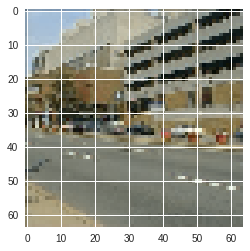

In [11]:
#plt.axis("off")
t=12
temp = recon_LR_img[t]
for i in range(64):
  for j in range(64):
    for k in range(3):
      if temp[i][j][k]>1 :
        temp[i][j][k] = 1
      elif temp[i][j][k]<0 :
        temp[i][j][k] = 0
plt.imshow(temp)

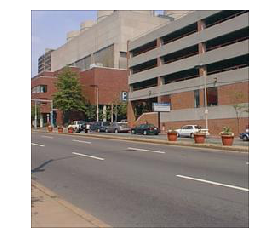

In [12]:
plt.axis("off")
plt.imshow(x_train[t])

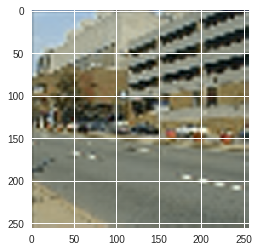

In [13]:
#plt.axis("off")
t=12
temp = recon_HR_img[t]
for i in range(256):
  for j in range(256):
    for k in range(3):
      if temp[i][j][k]>1 :
        temp[i][j][k] = 1
      elif temp[i][j][k]<0 :
        temp[i][j][k] = 0
plt.imshow(temp)

In [0]:
'''from nnlib import *
PER_CHANNEL_MEANS = np.array([0.47614917, 0.45001204, 0.40904046])

imgs = np.expand_dims(imgs, axis=0)
imgsize = np.shape(imgs)[1:]
print('processing %s' % fn)
xs = tf.placeholder(tf.float32, [1, imgsize[0], imgsize[1], imgsize[2]])
rblock = [resi, [[conv], [relu], [conv]]]
ys_est = NN('generator',
            [xs,
             [conv], [relu],
             rblock, rblock, rblock, rblock, rblock,
             rblock, rblock, rblock, rblock, rblock,
             [upsample], [conv], [relu],
             [upsample], [conv], [relu],
             [conv], [relu],
             [conv, 3]])
ys_res = tf.image.resize_images(xs, [4*imgsize[0], 4*imgsize[1]],
                                method=tf.image.ResizeMethod.BICUBIC)
ys_est += ys_res + PER_CHANNEL_MEANS
sess = tf.InteractiveSession()
tf.train.Saver().restore(sess, os.getcwd()+'/weights')
output = sess.run([ys_est, ys_res+PER_CHANNEL_MEANS],
                  feed_dict={xs: imgs-PER_CHANNEL_MEANS})
saveimg(output[0][0], 'output/%s-EnhanceNet.png' % fne)
saveimg(output[1][0], 'output/%s-Bicubic.png' % fne)
sess.close()
tf.reset_default_graph()'''